# Project 4 Fletcher 
## Part 3 clustering

### Explored frontier technology news in decades from New York Times API. Applied unsupervised machine learning methods to cluster different topics in tech news and compared the popular fields in time series.


Technology Trend in New York Times: rest API | NLP | LDA | Word2Vec | PCA | Clustering | MongoDB
<br>
• Summarized top topics from frontier technology news in 1945-2017 using New York Times API.
<br>
• Extracted public relationship network of aimed company from mass data.


In [33]:
from pymongo import MongoClient
import json
from copy import deepcopy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import multiprocessing
import gensim
import seaborn as sb  
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pickle
with open('tech1945_2017.plk','rb') as f:
    t=pickle.load(f)

In [3]:
lpdocs_yearly = []
for i in range(1945,2018):
    lpdocs_yearly.append([doc['lead_paragraph'] for doc in t[i] if doc['lead_paragraph']!=None])

In [4]:
len(lpdocs_yearly)

73

# WORD2VEC
## Take year of 2015 for instance.

### Clean the word before put into word2vec
### Must be word in sentences, must have frequency
I. let tag do most work, 

-1. split ngram(1,2)

-2. tag

II. clean them before put into word2vec

-1. split ngram(1,2)

-2. stop words with self-defined stopwords list

-3. stem

-AND modulize it

In [5]:
#lpdocs_yearly[-1] is lpdocs_yearly(2017),
lp2015 = deepcopy(lpdocs_yearly[-3])

In [6]:
print(len(lp2015),type(lp2015[0]))

2994 <class 'str'>


In [7]:
def get_ngrams(text, n):
    n_grams = ngrams(word_tokenize(text), n)
    return [ ' '.join(grams) for grams in n_grams]

In [10]:
# my_words = ('science','technology','000','1','2')
# my_stop_words = text.ENGLISH_STOP_WORDS.union(my_words)
vectorizer = CountVectorizer(ngram_range=(1,2),max_df=0.01,lowercase=False,stop_words='english',)
# call `fit` to build the vocabulary
x = vectorizer.fit_transform(lp2015)
# set(text.ENGLISH_STOP_WORDS)

# then, use `get_feature_names` to return the tokens
lp2015_c = vectorizer.vocabulary_

In [13]:
my_words = ('')
lp2015_stopped = lp2015
stoplist = text.ENGLISH_STOP_WORDS.union(my_words)

for word in stoplist:
    lps = []
    for lp in lp2015_stopped:
        lps.append(lp.replace(' '+word+' ',' '))
    lp2015_stopped = lps

print(type(lp2015_stopped), len(lp2015_stopped))
print(type(lp2015_stopped[0]), len(lp2015_stopped[0]))

<class 'list'> 2994
<class 'str'> 57


In [19]:
lp2015_split=[]
for sen in lp2015_stopped:
    lp2015_split.append(get_ngrams(sen,1)+get_ngrams(sen,2))

### tagging

In [15]:
lp2015_tag=[]
for lp in lp2015_split:
    lp2015_tag += pos_tag(lp)

In [16]:
lp2015_tag_tree = ne_chunk(lp2015_tag)

### IBO tagging

In [17]:
lp2015_iob_tagged = tree2conlltags(lp2015_tag_tree)

In [19]:
lp2015_iob_tagged[0]

('Farhad', 'NNP', 'B-PERSON')

In [20]:
lp2015_iob_org = [[p[0]] for p in lp2015_iob_tagged if (p[2]=='B-ORGANIZATION' or p[2]=='I-ORGANIZATION') and p[1]=='NNP']

In [21]:
lp2015_iob_person = [[p[0]] for p in lp2015_iob_tagged if (p[2]=='B-PERSON' or p[2]=='I-PERSON') and p[1]=='NNP']

In [22]:
lp2015_iob_wide = [[p[0]] for p in lp2015_iob_tagged if p[1]=='NNP']

In [24]:
lp2015_PO = lp2015_iob_org + lp2015_iob_person

In [26]:
type(lp2015_PO[0][0])
len(lp2015_PO)

24338

### End of taking nouns

In [24]:
num_features =100
context_size=7
min_word_count=3
num_workers=multiprocessing.cpu_count()

lp2015_vec=gensim.models.Word2Vec(
    lp2015_split,
    size =num_features,
    window = context_size,
    min_count=min_word_count,
    workers = num_workers,
    sg=1,
    seed=1)

In [25]:
lp2015_vec.save('lp2015_vec')
lp2015_vec=gensim.models.Word2Vec.load('lp2015_vec')

#topic similarity
#index on names
#main topics
#time importance on the name
#documnet 

In [26]:
lp2015_vec.most_similar(positive=['Bezos','Zuckerberg'], negative=['Sandberg'])

[('executive', 0.9638394713401794),
 ('include', 0.9628229141235352),
 ('chief', 0.961362361907959),
 ('today', 0.9611568450927734),
 ('things', 0.957926869392395),
 ('Pao', 0.9573480486869812),
 ('Mayer', 0.9524446129798889),
 ('job', 0.9514341354370117),
 ('collection', 0.9501936435699463),
 ('share', 0.9495557546615601)]

In [27]:
from sklearn.decomposition import PCA
leadp_matrix=PCA(n_components=2,random_state=0).fit_transform(lp2015_vec.wv.syn0)

In [28]:
# from sklearn.manifold import TSNE
# leadp_matrix2d=TSNE(n_components=2,random_state=0).fit_transform(leadp_matrix)

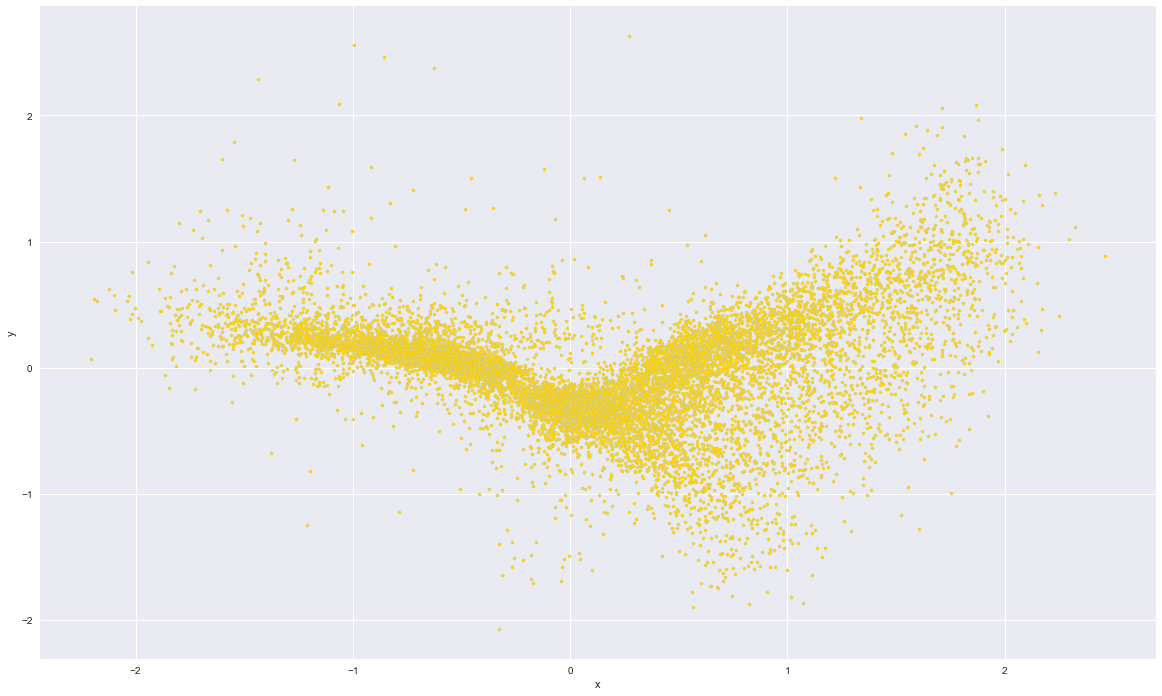

In [31]:
points = pd.DataFrame(
    [(word, coords[0], coords[1])
        for word, coords in [
            (word, leadp_matrix[lp2015_vec.wv.vocab[word].index])
            for word in lp2015_vec.wv.vocab]],
    columns=["word", "x", "y"])

points.plot.scatter("x", "y", s=10, color='gold', edgecolor='silver', figsize=(20, 12))

# for word, x, y in zip(lp2015_vec.wv.vocab, points['x'], points['y']):  
#     sb.plt.annotate(word, (x, y), size=12)

In [27]:
points.head()
points.shape

(14770, 3)

In [92]:
data = points[['x','y']].values

In [107]:
# from sklearn.preprocessing import scale
# scaled_data=scale(x_back,with_mean=False)


from sklearn.cluster import KMeans
km=KMeans(n_clusters=6,init='k-means++', max_iter=100, n_init=1)
# create clusters from transformed data
clusters=km.fit_predict(data)

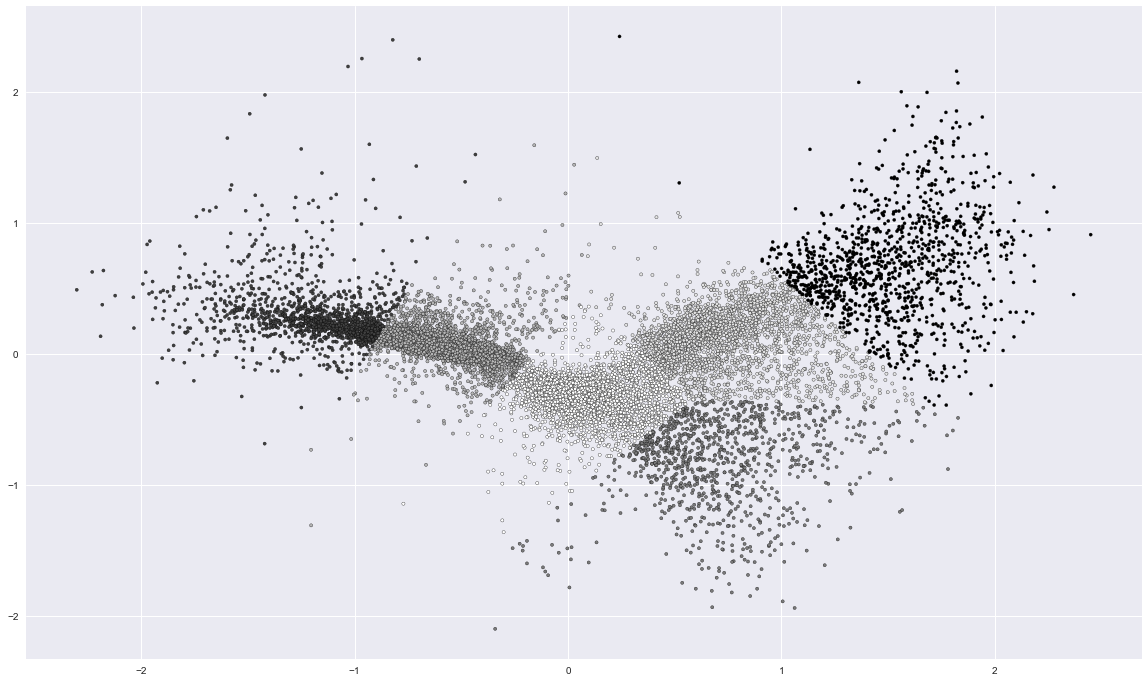

In [118]:
plt.figure(figsize=(20, 12))
plt.scatter([p[0] for p in data],[p[1] for p in data],c=clusters, s=10, edgecolor='black')
plt.show()

In [105]:
from sklearn.cluster import DBSCAN 
dbscan = DBSCAN(eps=0.5, min_samples =5,metric ='euclidean')
clusters_dbscan=dbscan.fit_predict(data)

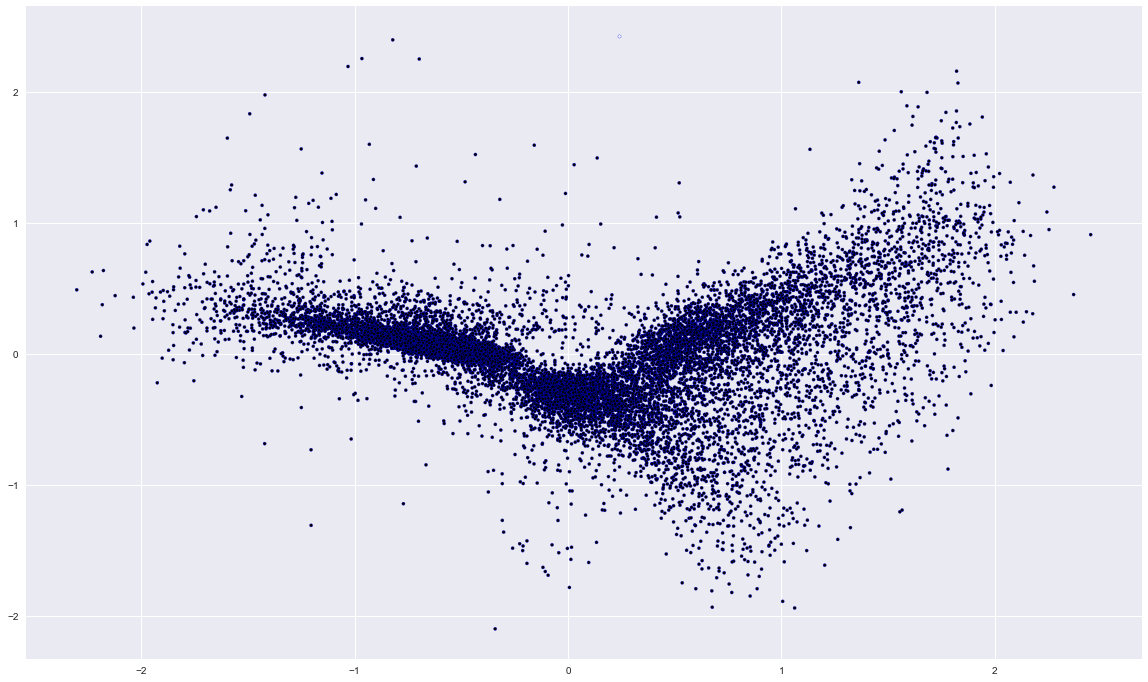

In [106]:
plt.figure(figsize=(20, 12))
plt.scatter([p[0] for p in data],[p[1] for p in data],c=clusters_dbscan, s=10, edgecolor='blue')
plt.show()

In [116]:
from sklearn.cluster import AgglomerativeClustering
ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit_predict(data)

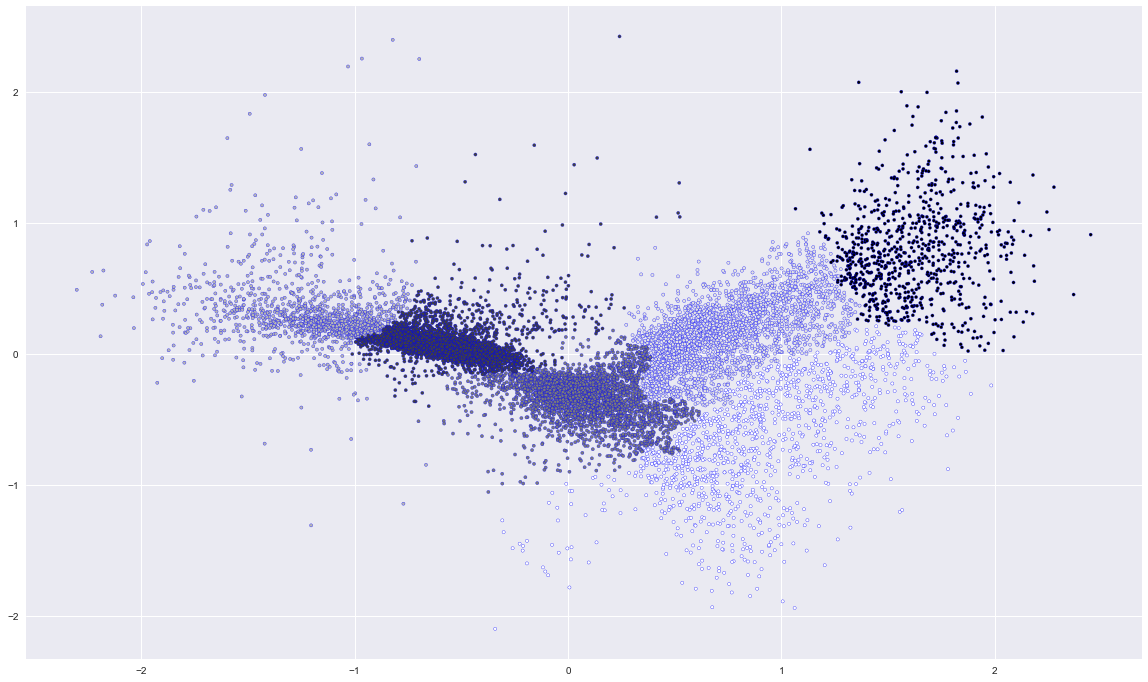

In [117]:
plt.figure(figsize=(20, 12))
plt.scatter([p[0] for p in data],[p[1] for p in data],c=ward, s=10, edgecolor='blue')
plt.show()

(0, 1)

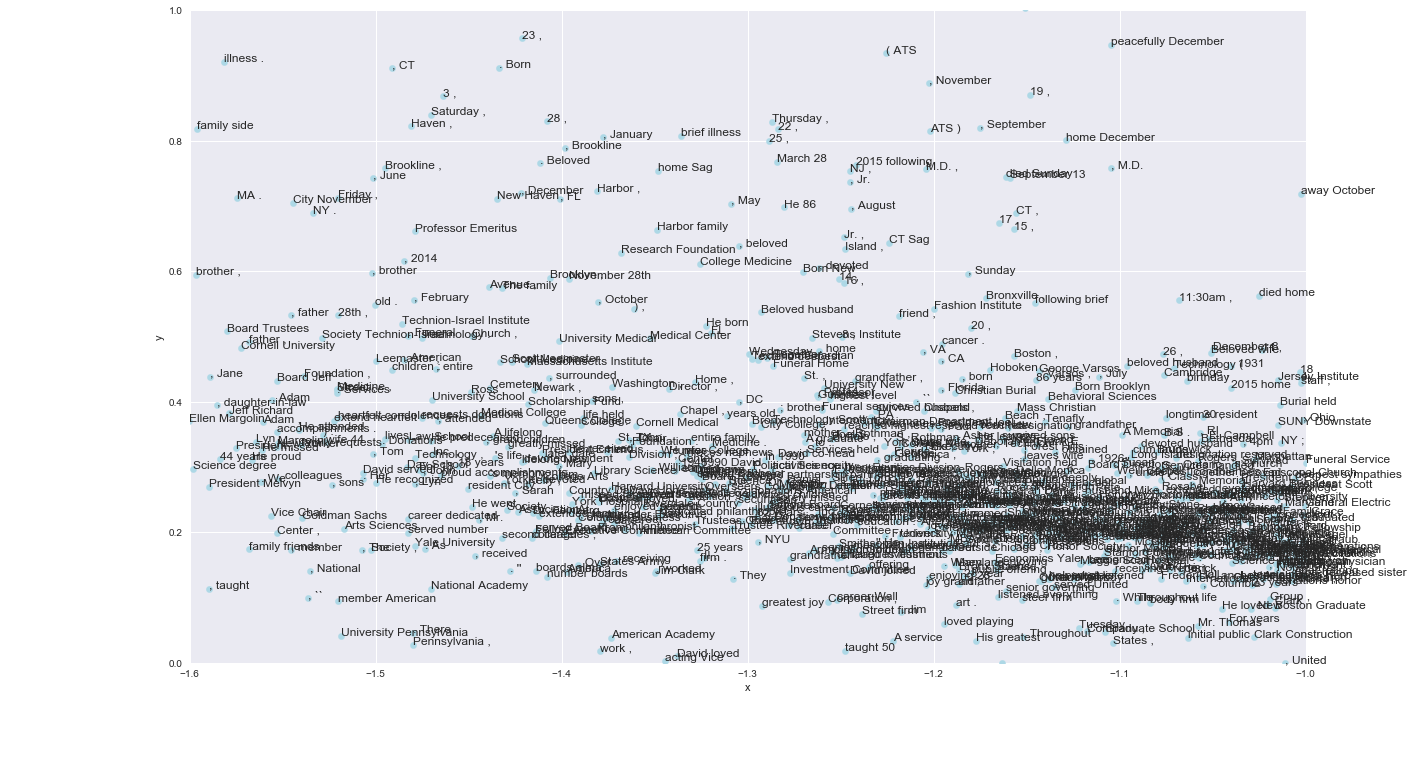

In [120]:
#section1
points.plot.scatter("x", "y", s=40, color='lightblue', figsize=(20, 12))
for word, x, y in zip(lp2015_vec.wv.vocab, points['x'], points['y']):  
    sb.plt.annotate(word, (x, y), size=12)
sb.plt.xlim(-1.6, -1)  
sb.plt.ylim(0, 1) 

(-0.01, 0.1)

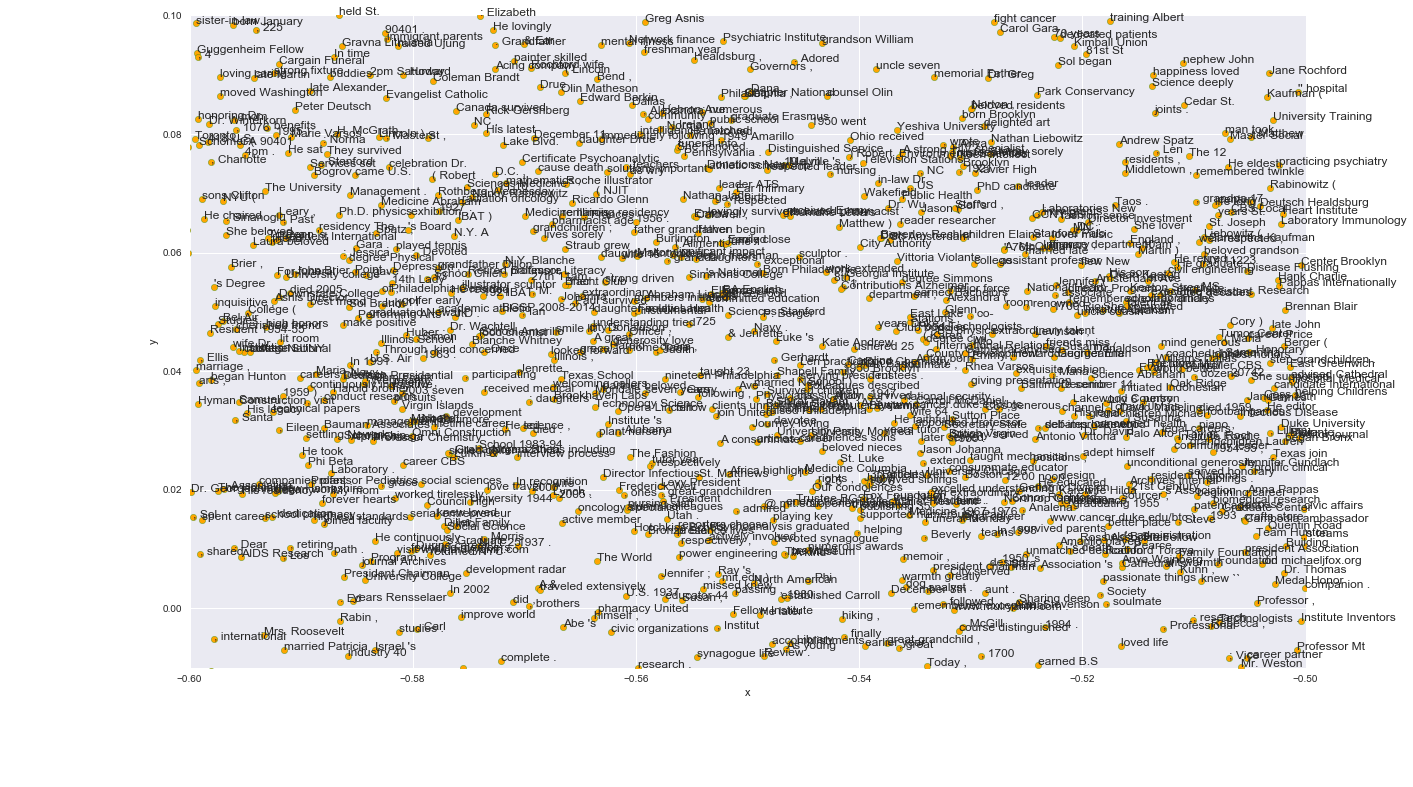

In [119]:
#section2
points.plot.scatter("x", "y", s=40, color='orange', edgecolor='green', figsize=(20, 12))
for word, x, y in zip(lp2015_vec.wv.vocab, points['x'], points['y']):  
    sb.plt.annotate(word, (x, y), size=12)
sb.plt.xlim(-0.6, -0.5)  
sb.plt.ylim(-0.01, 0.1) 

(-0.6, -0.2)

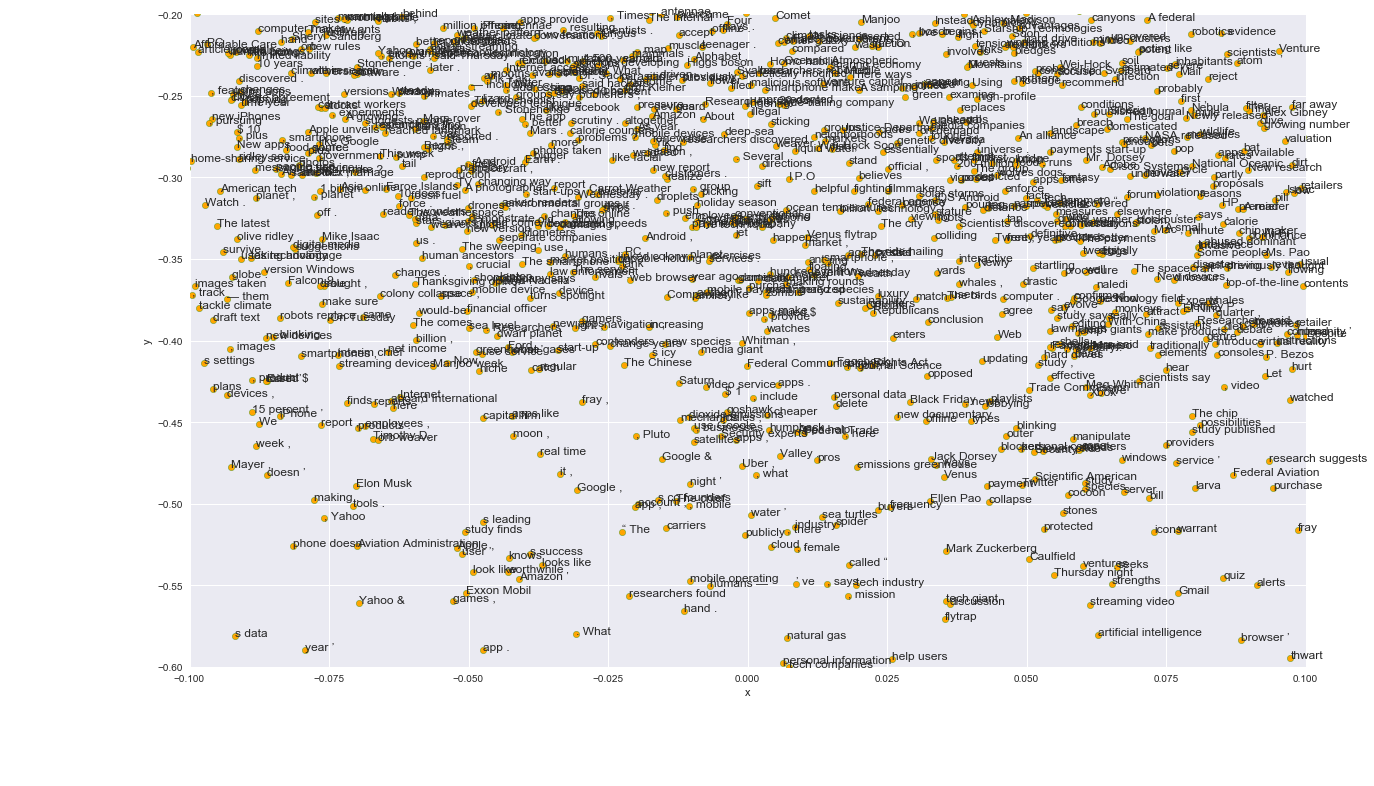

In [121]:
#section3
points.plot.scatter("x", "y", s=40, color='orange', edgecolor='green', figsize=(20, 12))
for word, x, y in zip(lp2015_vec.wv.vocab, points['x'], points['y']):  
    sb.plt.annotate(word, (x, y), size=12)
sb.plt.xlim(-0.1, 0.1)  
sb.plt.ylim(-0.6, -0.2) 

(-0.1, 0.5)

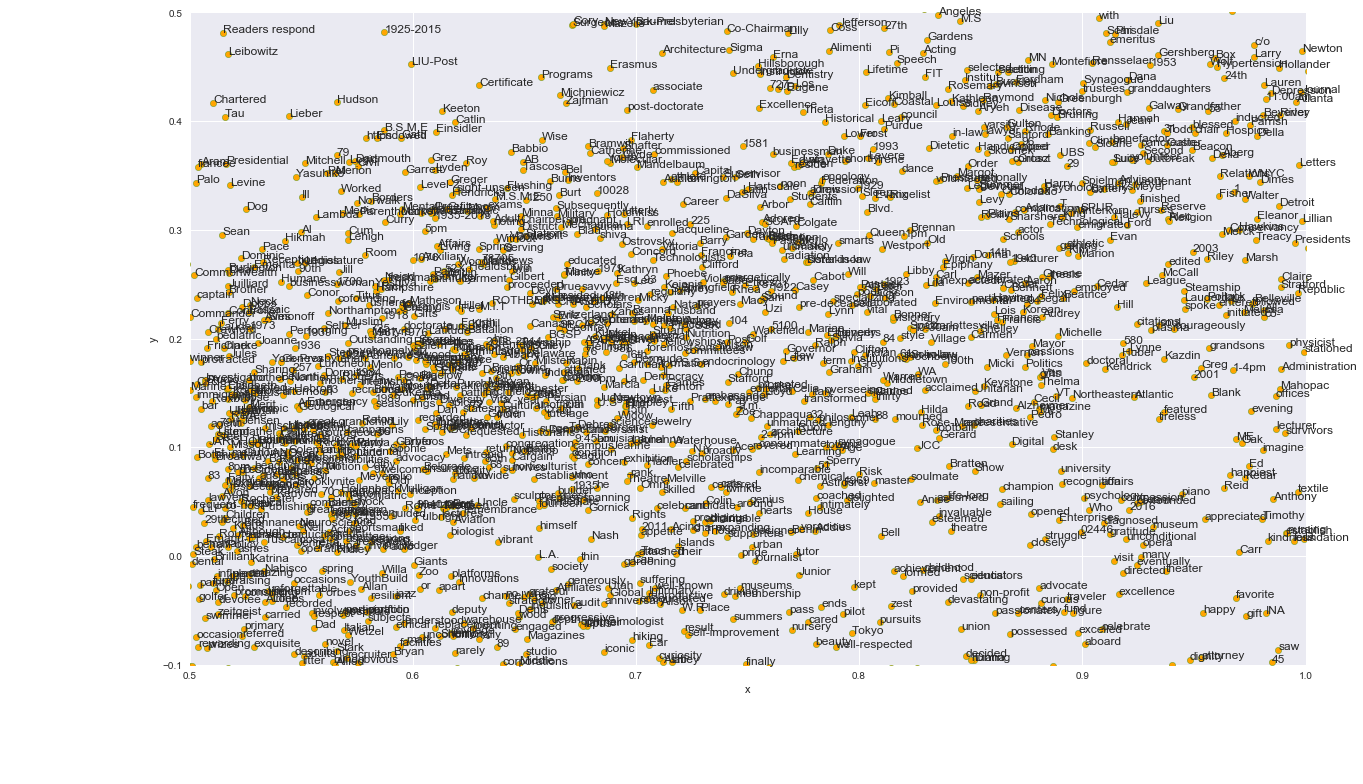

In [122]:
#section4
points.plot.scatter("x", "y", s=40, color='orange', edgecolor='green', figsize=(20, 12))
for word, x, y in zip(lp2015_vec.wv.vocab, points['x'], points['y']):  
    sb.plt.annotate(word, (x, y), size=12)
sb.plt.xlim(0.5, 1)  
sb.plt.ylim(-0.1, 0.5) 

(-1.5, -0.5)

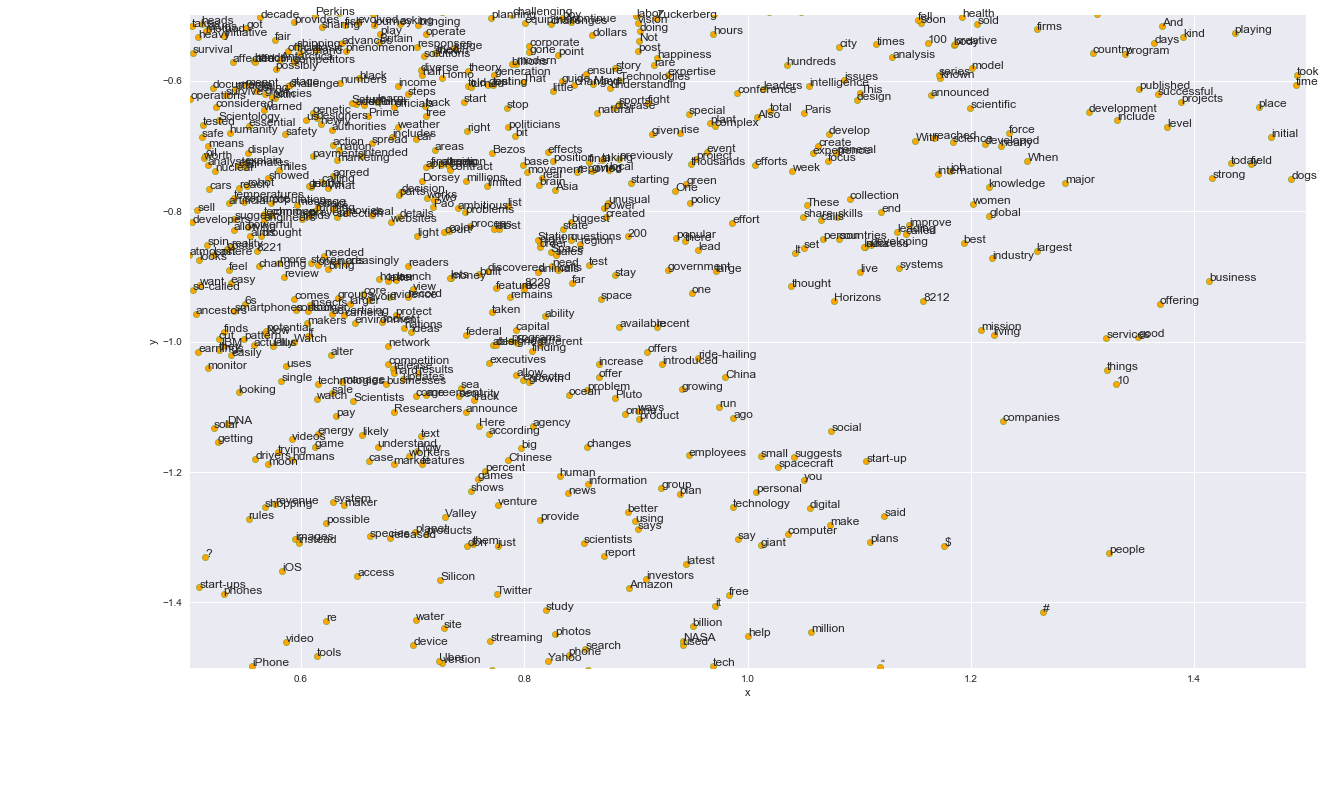

In [123]:
#section5
points.plot.scatter("x", "y", s=40, color='orange', edgecolor='green', figsize=(20, 12))
for word, x, y in zip(lp2015_vec.wv.vocab, points['x'], points['y']):  
    sb.plt.annotate(word, (x, y), size=12)
sb.plt.xlim(0.5, 1.5)  
sb.plt.ylim(-1.5, -0.5) 

(0.5, 1.5)

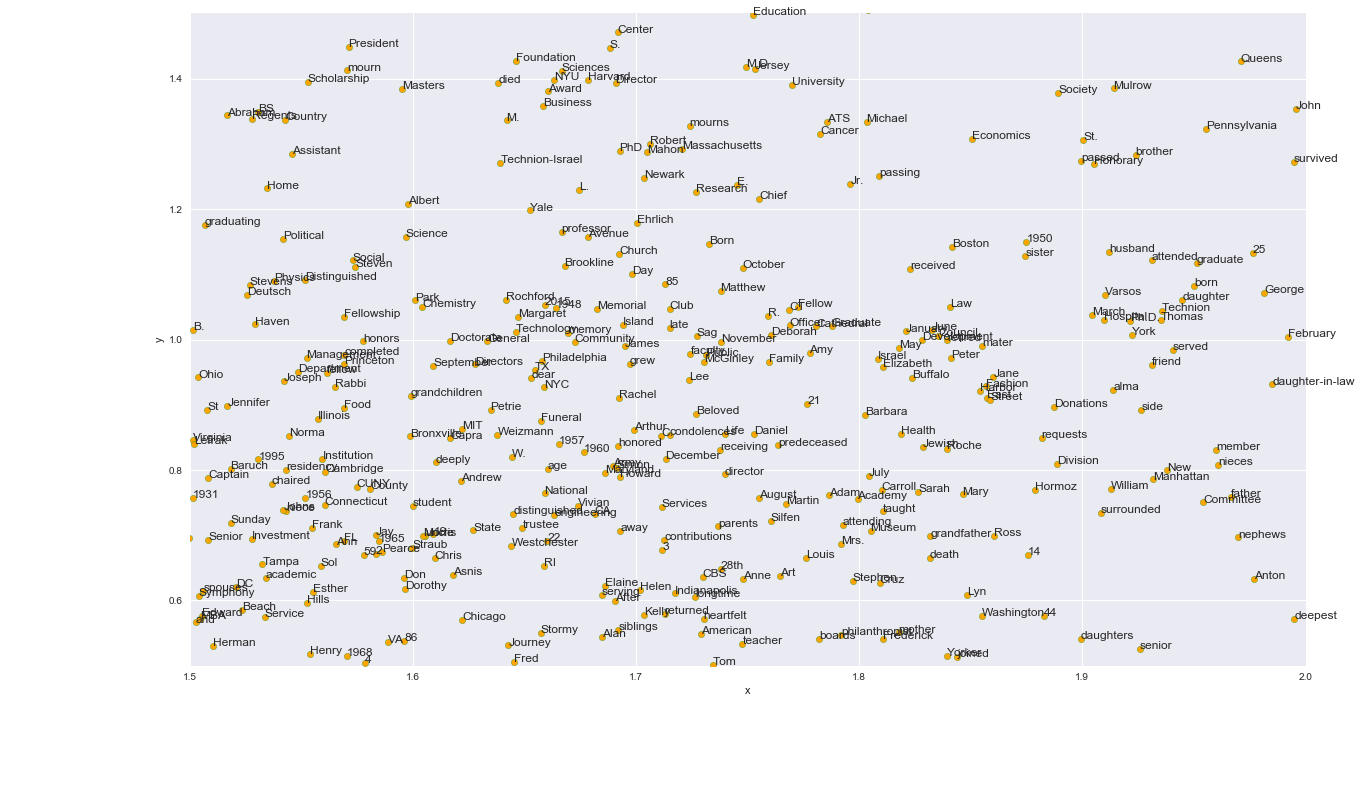

In [124]:
#section6
points.plot.scatter("x", "y", s=40, color='orange', edgecolor='green', figsize=(20, 12))
for word, x, y in zip(lp2015_vec.wv.vocab, points['x'], points['y']):  
    sb.plt.annotate(word, (x, y), size=12)
sb.plt.xlim(1.5, 2)  
sb.plt.ylim(0.5, 1.5) 